# ANALYSE PAR TYPE DES TICKETS

**C'est un notebook où je teste des choses, les codes que j'ai utilisés et que j'ai présentés dans mon ppt et dans mon rapport sont dans le notebook "analyse de la source des tickets"**

### imports des modules et du dataset

In [16]:
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, mean_absolute_error
warnings.filterwarnings("ignore")
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import math
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from pmdarima import auto_arima
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from pandas.plotting import autocorrelation_plot

In [17]:
os.chdir('C:\\Users\\matthias.picard\\Downloads\\données consort')
statique=pd.read_excel('Static_data.xlsx')

In [4]:
statique.head()

,Ticket_id,Type_Ticket,Date_deb,Date_due,Date_res,Date_clo,Delai_att,Delai_res,Delai_clo,Content,...,Source,Solution,Entite,Priority,Impact,Urgency,Satisfaction,Satisfaction_comment,Problem_name,Location
0,134431,Demande,2020-09-29 10:10:30,2020-10-01 10:10:30,NaT,NaT,0.0,0.0,0.0,Description dÃ©taillÃ©e du changement=xxxxxxxx...,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN
1,134430,Demande,2020-09-29 10:05:40,2020-10-01 10:05:40,NaT,NaT,0.0,0.0,0.0,Description dÃ©taillÃ©e du changement=xxxxxxxx...,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN
2,134429,Demande,2020-09-29 09:47:36,2020-10-01 09:47:36,NaT,NaT,0.0,0.0,0.0,TEST,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN
3,134428,Demande,2020-09-28 19:20:41,2020-09-30 18:30:00,NaT,NaT,0.0,0.0,0.0,test,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN
4,134427,Demande,2020-09-28 18:33:17,2020-09-30 18:30:00,NaT,NaT,0.0,0.0,0.0,Ceci est un test,...,Directe,NaN,CONSORT NT,Basse,Bas,Moyenne,NaN,NaN,NaN,NaN


Nous allons extraire de cette base de données le nombre de tickets par jour/heures/demi-journées. Notre repère temporel sera la colonne Date_deb 

### Préparation des données

#### preparation de la colonne 'Date_deb'

In [18]:
statique.drop(np.arange(97253,97970,1), inplace=True)

entre les lignes 97253 et 97970 de la colonne Date_deb on ne retrouve que des nan. On est obligé de les enlever pour convertir la colonne en DateTime et s'en servir comme index temporelle

In [19]:
statique['Date_deb']=pd.to_datetime(statique['Date_deb'])

statique_heures=statique.copy()
statique_heures['Date_deb'] = statique_heures.Date_deb.dt.floor(freq='H') 
statique_heures.set_index('Date_deb',inplace=True)


statique_demijours=statique.copy()
statique_demijours['Date_deb'] = statique_demijours.Date_deb.dt.floor(freq='12h') 
statique_demijours.set_index('Date_deb',inplace=True)


statique_jours=statique.copy()
statique_jours['Date_deb'] = statique_jours.Date_deb.dt.floor(freq='D') 
statique_jours.set_index('Date_deb',inplace=True)

on crée plusieurs dataset selon en regroupant les tickets selon leurs heures/jours/dates de créations

### Dynamique des types de tickets par jours

In [20]:
statique_jours_demandes=statique_jours[statique_jours['Type_Ticket']=='Demande']
statique_jours_incidents=statique_jours[statique_jours['Type_Ticket']!='Demande']

On va commencer à s'interesser à création de ticket demandes et tickets incidents par jours.

In [21]:
nb_ticket_jours_demandes=pd.DataFrame(statique_jours_demandes.index.value_counts())
ticket_jours_demandes=nb_ticket_jours_demandes.reset_index().sort_values(by='index').set_index('index').asfreq('d')
ticket_jours_demandes[ticket_jours_demandes.isna()]=0
ticket_jours_demandes.rename(columns={'Date_deb':'nb_tickets'},inplace=True)
ticket_jours_demandes

,nb_tickets
index,
2011-10-17,1.0
2011-10-18,0.0
2011-10-19,0.0
2011-10-20,0.0
2011-10-21,0.0
...,...
2020-09-25,39.0
2020-09-26,2.0
2020-09-27,0.0


On obtient ici un dataset du nombre de tickets demandes crée chaques jours entre le 2011/10/17 et le 2020-09-29

In [22]:
nb_ticket_jours_incidents=pd.DataFrame(statique_jours_incidents.index.value_counts())
ticket_jours_incidents=nb_ticket_jours_incidents.reset_index().sort_values(by='index').set_index('index').asfreq('d')
ticket_jours_incidents[ticket_jours_incidents.isna()]=0
ticket_jours_incidents.rename(columns={'Date_deb':'nb_tickets'},inplace=True)
ticket_jours_incidents

,nb_tickets
index,
2012-01-02,7.0
2012-01-03,6.0
2012-01-04,11.0
2012-01-05,7.0
2012-01-06,9.0
...,...
2020-09-22,24.0
2020-09-23,27.0
2020-09-24,8.0


Pareil mais pour les tickets incidents

<Figure size 432x288 with 0 Axes>

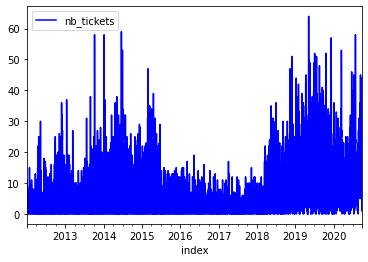

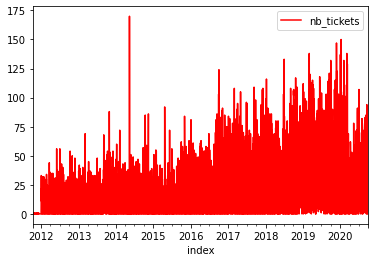

In [14]:
plt.figure()

ticket_jours_incidents.plot(c='blue',label='incidents')
ticket_jours_demandes.plot(c='red',label='demandes')
plt.legend()

Le premier graphique montre la répartition des incidents au cours du temps. La dynamique est assez différentes de celle du graphe avec l'ensemble des tickets: la tendance n'est pas linéaire (peu d'incident entre 2016 et 2018), et on peut constater la présence de nombreux pics d'incidents.

Le graphe des demandes ressemble beaucoup plus à celui avec tout les types de tickets ( nottament parce que l'on trouve plus de demande que d'incidents: 96832 pour 29970).

Regardons ce qu'il se passe durant la période ou le nombre d'incident semble anormalement bas:

### Analyse des incidents entre 2016 et 2018

#### value_counts des sources

<AxesSubplot:xlabel='index', ylabel='Source'>

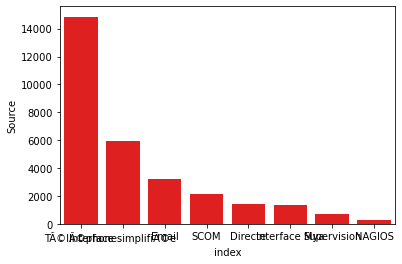

In [71]:
sns.barplot(data=pd.DataFrame(statique_jours_incidents.Source.value_counts().reset_index()),
            x='index',
            y='Source',color='red')

In [72]:
statique_jours_incidents.Source.value_counts()

TÃ©lÃ©phone              14854
Interface simplifiÃ©e     5952
Email                     3231
SCOM                      2118
Directe                   1425
Interface Mya             1353
Supervision                733
NAGIOS                     303
Name: Source, dtype: int64

<AxesSubplot:xlabel='index', ylabel='Source'>

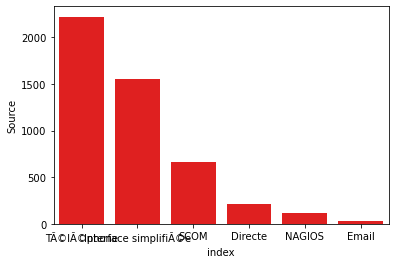

In [70]:
sns.barplot(data=pd.DataFrame(statique_jours_incidents.loc['2015/06':'2018/04',:].Source.value_counts().reset_index()),
            x='index',
            y='Source',color='red')

In [73]:
statique_jours_incidents.loc['2015/06':'2018/04',:].Source.value_counts()

TÃ©lÃ©phone              2221
Interface simplifiÃ©e    1555
SCOM                      665
Directe                   215
NAGIOS                    122
Email                      33
Name: Source, dtype: int64

les mails sont quasi-inexistants dans la periode, et on ne trouve personne qui à utiliser MyA

#### value_counts des Entités

<AxesSubplot:xlabel='index', ylabel='Entite'>

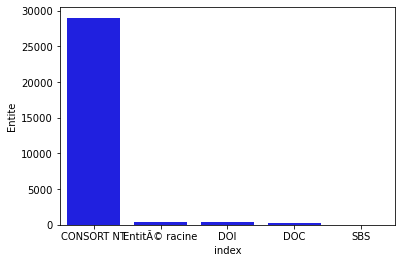

In [77]:
sns.barplot(data=pd.DataFrame(statique_jours_incidents.Entite.value_counts().reset_index()),
            x='index',
            y='Entite',color='blue')

In [76]:
statique_jours_incidents.Entite.value_counts()

CONSORT NT        29003
EntitÃ© racine      419
DOI                 341
DOC                 200
SBS                   6
Name: Entite, dtype: int64

<AxesSubplot:xlabel='index', ylabel='Entite'>

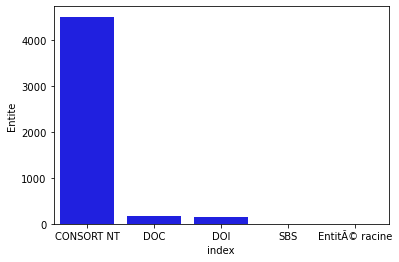

In [74]:
sns.barplot(data=pd.DataFrame(statique_jours_incidents.loc['2015/06':'2018/04',:].Entite.value_counts().reset_index()),
            x='index',
            y='Entite',color='blue')

In [75]:
statique_jours_incidents.loc['2015/06':'2018/04',:].Entite.value_counts()

CONSORT NT        4503
DOC                162
DOI                137
SBS                  6
EntitÃ© racine       3
Name: Entite, dtype: int64

<AxesSubplot:>

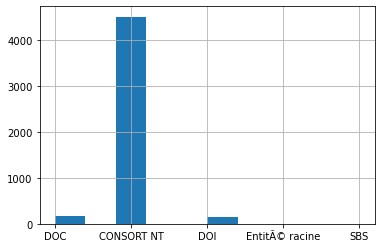

In [42]:
sns.barplot(statique_jours_incidents.loc['2015/06':'2018/04',:].Entite.hist()

Pas vraiment de changement significatfs lorsque l'on s'interressent aux entités concernées par les incidents signalés dans la période

## tests de modèles

**Pour tout nos modèles on essayera d'appliquer nos prédictions sur la période juillet-septembre (et pas avant, pour éviter la période du confinement, qui n'est pas représentative)**

Commençons par appliquer des modèles Prophet sans tuning aux incidents et aux demandes

### Prophet (simple) __incidents

In [103]:
ticket_jours_incidents_prophet=ticket_jours_incidents.reset_index().rename(columns={'index':'ds','nb_tickets':'y'})

trainset_simple_incidents_prophet=ticket_jours_incidents_prophet.loc[:'3100',:]
testset_simple_incidents_prophet=ticket_jours_incidents_prophet.loc['3100':,:]


In [104]:
model_simple_incidents_prophet = Prophet(daily_seasonality=False)
model_simple_incidents_prophet.fit(trainset_simple_incidents_prophet)
future_simple_incidents_prophet = model_simple_incidents_prophet.make_future_dataframe(periods=91)
forecast_simple_incidents_prophet = model_simple_incidents_prophet.predict(future_simple_incidents_prophet)

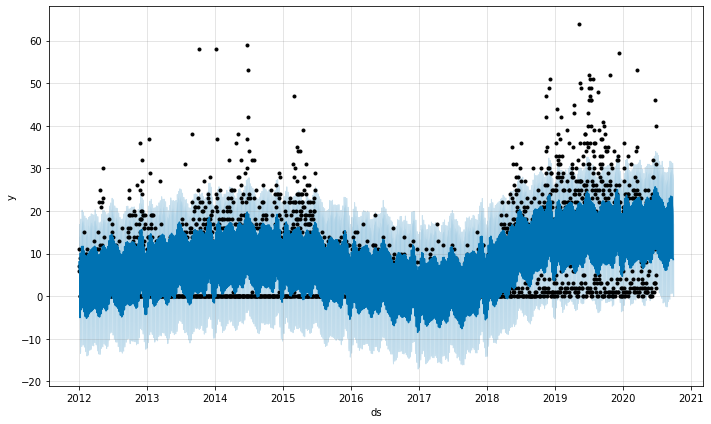

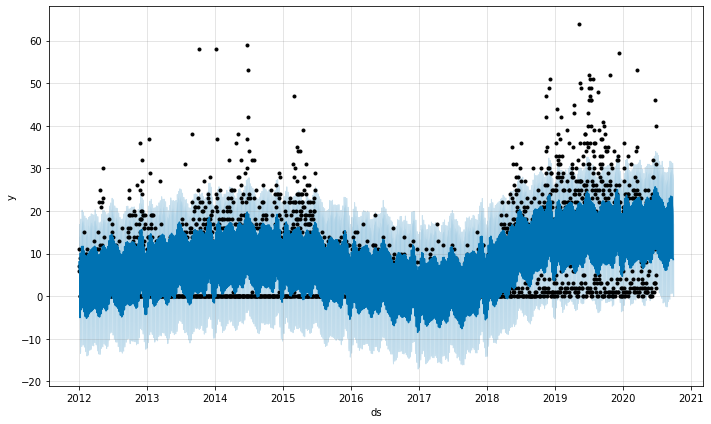

In [105]:
model_simple_incidents_prophet.plot(forecast_simple_incidents_prophet)

la période de 2016-2018 trouble la tendance general (il faudra peut-etre la modifier...)

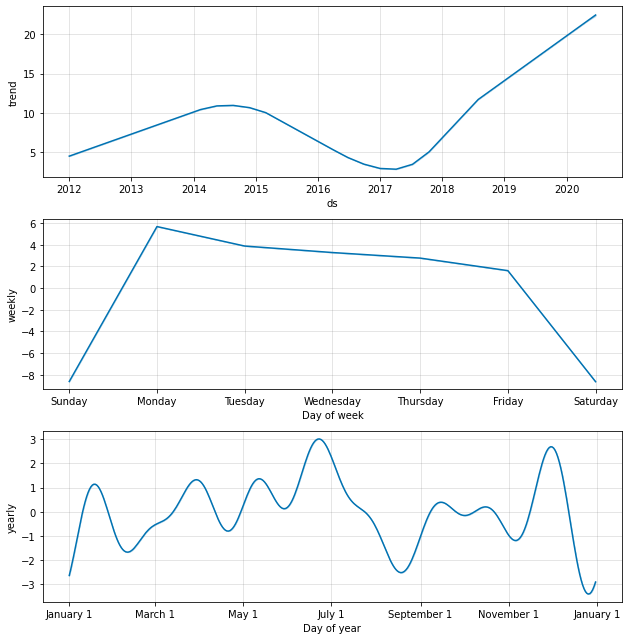

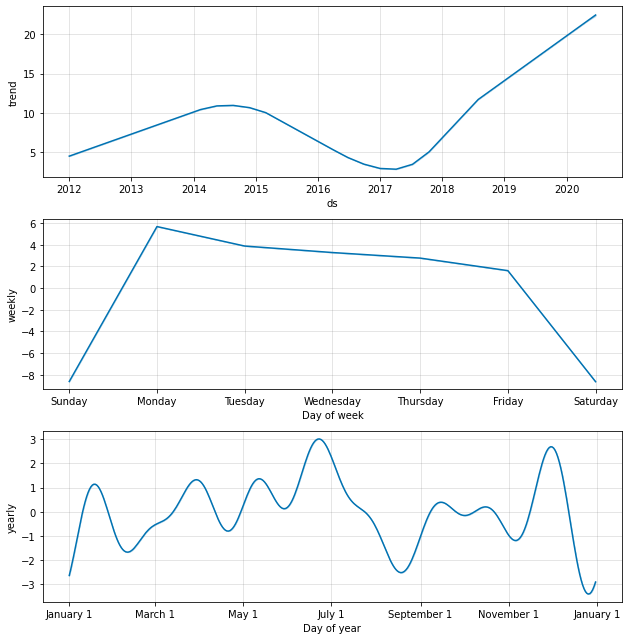

In [101]:
model_simple_incidents_prophet.plot_components(forecast_simple_incidents_prophet)

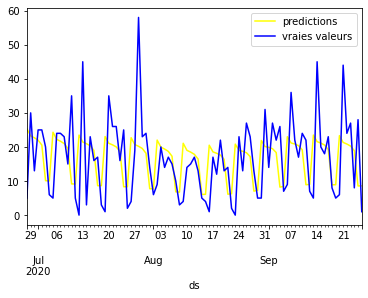

In [106]:
predictions_simple_incidents_prophet=pd.DataFrame(forecast_simple_incidents_prophet.loc[3101:,'yhat'])
predictions_simple_incidents_prophet.set_index(testset_simple_incidents_prophet['ds'],inplace=True)
plt.figure()
predictions_simple_incidents_prophet['yhat'].plot(c='yellow',label='predictions')
plt.plot(testset_simple_incidents_prophet['ds'],testset_simple_incidents_prophet['y'],c='blue',label='vraies valeurs')
plt.legend()

In [121]:
(mean_squared_error(predictions_simple_incidents_prophet['yhat'],testset_simple_incidents_prophet['y']),
mean_absolute_percentage_error(predictions_simple_incidents_prophet['yhat'],testset_simple_incidents_prophet['y']))

(129.924817535585, 0.5530633231552037)

En moyenne 55 % d'erreur entre la prédiction et la vrai valeur....

Sur la detection d'incidents Prophet  semble plutôt bien suivre la tendance géneral au cours de l'année (moins d'incidents en aout, plus d'incident en septembre...). Mais il ne prend pas en compte la saisonnalité par semaine ( il ya très souvent un pic en début de semaine, mais Prophet sous-estime souvent ce pic). Il a aussi souvent tendance à surestimer les incidents le week-end (augmenter l'impact de la saisonnalité par semaine?)

On peut aussi remarquer que ces pics sont beaucoup moins présent le mois d'août. Doit-on rajouter une saisonnalité liée aux vacances? 

### Prophet (simple)__demandes

In [116]:
ticket_jours_demandes_prophet=ticket_jours_demandes.reset_index().rename(columns={'index':'ds','nb_tickets':'y'})

trainset_simple_demandes_prophet=ticket_jours_demandes_prophet.loc[:'3150',:]
testset_simple_demandes_prophet=ticket_jours_demandes_prophet.loc['3150':,:]

In [117]:
model_simple_demandes_prophet = Prophet(daily_seasonality=False)
model_simple_demandes_prophet.fit(trainset_simple_demandes_prophet)
future_simple_demandes_prophet = model_simple_demandes_prophet.make_future_dataframe(periods=121)
forecast_simple_demandes_prophet = model_simple_demandes_prophet.predict(future_simple_demandes_prophet)

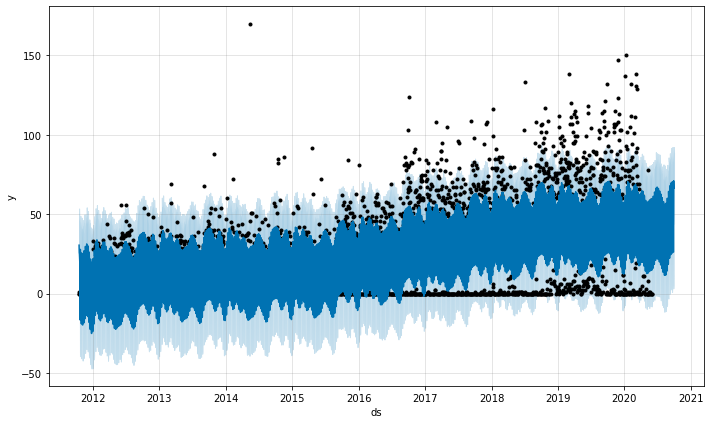

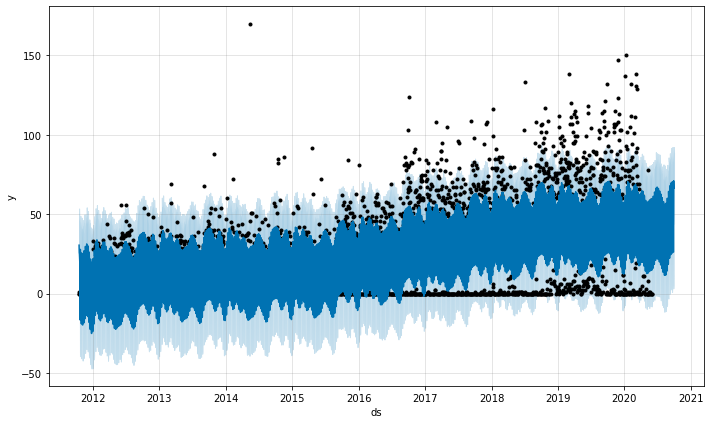

In [118]:
model_simple_demandes_prophet.plot(forecast_simple_demandes_prophet)

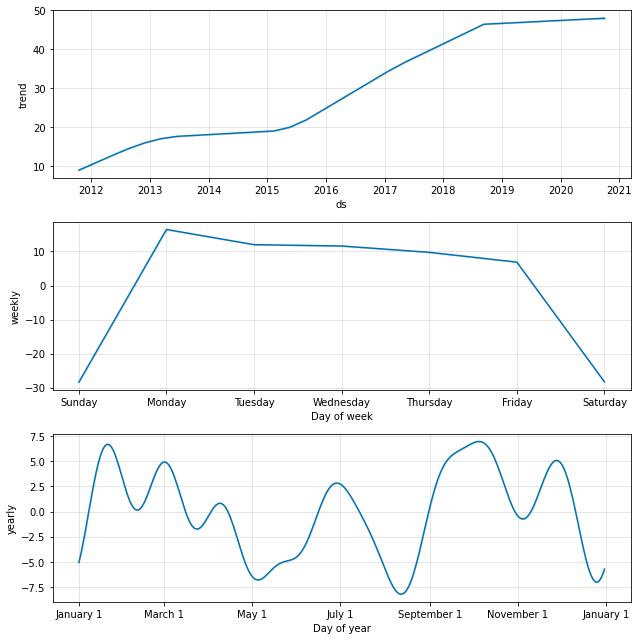

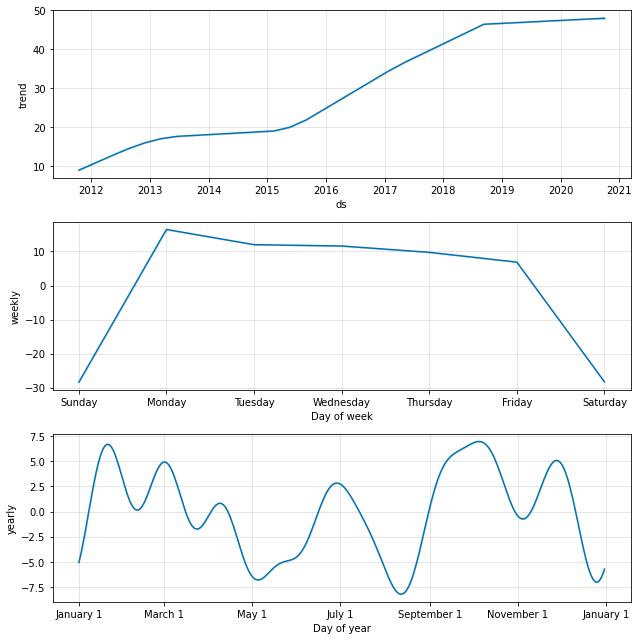

In [119]:
model_simple_demandes_prophet.plot_components(forecast_simple_demandes_prophet)

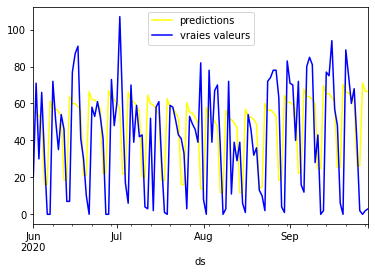

In [120]:
predictions_simple_demandes_prophet=pd.DataFrame(forecast_simple_demandes_prophet.loc[3151:,'yhat'])
predictions_simple_demandes_prophet.set_index(testset_simple_demandes_prophet['ds'],inplace=True)
plt.figure()
predictions_simple_demandes_prophet['yhat'].plot(c='yellow',label='predictions')
plt.plot(testset_simple_demandes_prophet['ds'],testset_simple_demandes_prophet['y'],c='blue',label='vraies valeurs')
plt.legend()


In [122]:
(mean_squared_error(predictions_simple_demandes_prophet['yhat'],testset_simple_demandes_prophet['y']),
mean_absolute_percentage_error(predictions_simple_demandes_prophet['yhat'],testset_simple_demandes_prophet['y']))

(962.295234843314, 0.6040455672293512)

60% d'erreurs en moyenne.

Ici, Prophet surestime considérablment la quantités de demandes crée pendant les week-end

### Prophet tunné__demandes

On va tenter d'améliorer notre prédiction en jouant sur les paramètres suivants: 
- saisonnalité mensuelle
- indiquer les jours de vacances
- traiter les périodes exceptionnelles ( confinement)

In [124]:
ticket_jours_demandes_prophet=ticket_jours_demandes.reset_index().rename(columns={'index':'ds','nb_tickets':'y'})

trainset_tunné_demandes_prophet=ticket_jours_demandes_prophet.loc[:'3150',:]
testset_tunné_demandes_prophet=ticket_jours_demandes_prophet.loc['3150':,:]

In [151]:
model_tunné_demandes_prophet= Prophet(growth='linear',yearly_seasonality=False
                 ,seasonality_prior_scale=25, weekly_seasonality=False
                 ).add_seasonality(name='yearly',period=365.25,fourier_order=10
                                  ).add_seasonality(name='weekly',period=7,fourier_order=10,prior_scale=50)

model_tunné_demandes_prophet.fit(trainset_tunné_demandes_prophet)
future_tunné_demandes_prophet= model_tunné_demandes_prophet.make_future_dataframe(periods=121)
forecast_tunné_demandes_prophet= model_tunné_demandes_prophet.predict(future_tunné_demandes_prophet)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


model_tunné_demandes_prophet.plot(forecast_tunné_demandes_prophet)

model_tunné_demandes_prophet.plot_components(forecast_tunné_demandes_prophet)

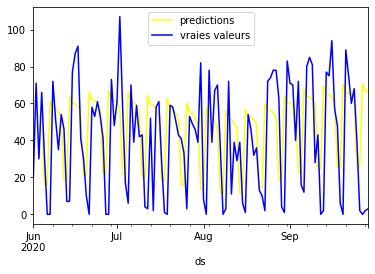

In [152]:
predictions_tunné_demandes_prophet=pd.DataFrame(forecast_tunné_demandes_prophet.loc[3151:,'yhat'])
predictions_tunné_demandes_prophet.set_index(testset_tunné_demandes_prophet['ds'],inplace=True)
plt.figure()
predictions_tunné_demandes_prophet['yhat'].plot(c='yellow',label='predictions')
plt.plot(testset_tunné_demandes_prophet['ds'],testset_tunné_demandes_prophet['y'],c='blue',label='vraies valeurs')
plt.legend()

In [153]:
(mean_squared_error(predictions_tunné_demandes_prophet['yhat'],testset_tunné_demandes_prophet['y']),
mean_absolute_percentage_error(predictions_tunné_demandes_prophet['yhat'],testset_tunné_demandes_prophet['y']))

(960.8891263005125, 0.6062567776981004)

#### (Voir comment améliorer ces modèles avec Vladimir)

### SARIMA et auto-arima

#### test de stationnarité

In [78]:
result_incidents = adfuller(ticket_jours_incidents['nb_tickets'].values)
result_demandes = adfuller(ticket_jours_demandes['nb_tickets'].values)
print(result_incidents[1],result_demandes[1])

0.032744760455073636 0.009274204402845668


Dans les deux cas la p-value est assez négligeable, on peut donc considerer les données comme étant stationnaires